# Part 7.2 - Applying Sentiment Analysis
---

### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import conf_pyspark, load_dataset
from utils_preplot import load_doctopic
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline
dpi=80

from sklearn.preprocessing import MinMaxScaler
import textblob as tb

from pyspark.sql import functions as F
from pyspark.sql.types import *

# intiate PySpark
sc, spark = conf_pyspark()

sc

[('spark.driver.host', 'x99.hub'),
 ('spark.app.id', 'local-1548549103699'),
 ('spark.app.name', 'local'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '46463'),
 ('spark.driver.memory', '62g'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.cores', '6'),
 ('spark.driver.maxResultSize', '4g')]


<SparkContext master=local[*] appName=local>

**Did people live with happyness or not? In this part we will apply a sentiment analysis process to topics to find the answer.**

**We consider each topic has a score of sentiment more or less, we can use a sentiment tool (TextBlob) to get the score. Then we multiply the score of each topic to the corresponding topic weight in average weight-year matrix, we get the sentiment-year matrix. This matrix is the answer of the question.**

## 1 Load Data

**Load metadata:**

In [2]:
df_meta = load_dataset('meta', spark).select(F.col('id').alias('id_'), F.col('region'), F.col('date'))
df_meta.cache()

DataFrame[id_: int, region: string, date: date]

In [3]:
df_meta.limit(5).toPandas().head()

,id_,region,date
0,1854215,Auckland,1862-06-14
1,1854221,Auckland,1862-06-14
2,1854224,Auckland,1862-07-03
3,1854233,Auckland,1863-08-01
4,1854245,Auckland,1863-09-01


**Topic List:**

In [4]:
path = r'../models/train/topicKeys.txt'

df_topics = (pd.read_table(path, 
                           header=None, 
                           index_col=None, 
                           names = ['topic', 'weight', 'keywords'],
                           encoding='utf8')
             .sort_values(by='topic')
             .reset_index(drop=True))

topics_shape = df_topics.shape
topic_number = df_topics.shape[0]

In [5]:
print('Shape of dataframe:', topics_shape)
df_topics.sample(5)

Shape of dataframe: (200, 3)


,topic,weight,keywords
181,181,0.00492,air london flying flight aeroplane miles british wireless machine aircraft bombs aeroplanes raid machines german pla...
43,43,0.00778,fund soldiers committee work relief funds war patriotic cross aid red society hospital received home appeal men mone...
35,35,0.00410,white black blue silk hat dress lace pink bride satin green wedding trimmed velvet pretty skirt coat flowers gold co...
187,187,0.01002,men military private army camp officers service war new_zealand soldiers defence colonel officer captain training wo...
194,194,0.00742,meeting motion thought moved chairman carried matter seconded committee present question resolution put asked propos...


**Load doc-topic matrix:**

In [6]:
path = r'../models/train/docTopics.txt'

df_doctopic = (load_doctopic(path, topics_shape[0], spark)).drop('index').orderBy('id')
df_doctopic.cache();

In [7]:
print('Shape of dataframe:({}, {})'.format(df_doctopic.count(), len(df_doctopic.columns)))
df_doctopic.limit(5).toPandas().head()

Shape of dataframe:(1814086, 201)


,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1854215,0.000033,0.000132,0.000118,0.000131,0.000171,0.000668,0.000116,0.000187,0.000273,0.000064,0.000112,0.000099,0.000060,0.000059,0.000085,0.000147,0.000094,0.000080,0.000199,0.000119,0.000104,0.000062,0.000165,0.000138,0.000107,0.000165,0.000194,0.000101,0.017802,0.000194,0.000138,0.000077,0.000127,0.000134,0.000149,0.000070,0.000114,0.000213,0.000095,0.000208,0.000109,0.000036,0.000136,0.000133,0.000133,0.000115,0.000147,0.000116,0.000129,0.000086,0.000236,0.000124,0.000107,0.000105,0.000113,0.000115,0.000103,0.000175,0.000157,...,0.000030,0.000227,0.000114,0.000099,0.000075,0.000087,0.000079,0.000069,0.017168,0.000104,0.000114,0.000138,0.000066,0.000118,0.000102,0.000109,0.000042,0.000033,0.000024,0.000101,0.000105,0.000043,0.000095,0.000189,0.000315,0.000096,0.000114,0.000144,0.000021,0.000219,0.273583,0.000145,0.000116,0.000110,0.000030,0.000141,0.000284,0.000111,0.000225,0.000189,0.000117,0.000084,0.000116,0.000089,0.000220,0.000031,0.000224,0.000171,0.000076,0.000103,0.000158,0.000101,0.000052,0.000181,0.000127,0.000154,0.000169,0.000111,0.000106,0.000110
1,1854221,0.000047,0.000186,0.000166,0.000184,0.000240,0.000942,0.000163,0.000264,0.000384,0.000090,0.000158,0.000140,0.000085,0.000083,0.000120,0.000207,0.000133,0.000113,0.000280,0.000167,0.000146,0.000088,0.000233,0.000194,0.000151,0.000232,0.000274,0.000142,0.025093,0.000273,0.000194,0.000109,0.000179,0.000190,0.000210,0.000099,0.000160,0.000300,0.000134,0.000293,0.000154,0.000050,0.000191,0.000187,0.000187,0.000162,0.000207,0.000164,0.000182,0.000121,0.000333,0.000175,0.000151,0.000147,0.000159,0.000162,0.000145,0.000246,0.000221,...,0.000042,0.000320,0.000161,0.000139,0.000106,0.000122,0.000112,0.000098,0.000108,0.000147,0.000161,0.000194,0.000092,0.000167,0.000143,0.000154,0.000059,0.000047,0.000034,0.000142,0.000148,0.000060,0.000134,0.000266,0.000443,0.000135,0.000160,0.000203,0.000029,0.000309,0.000164,0.000205,0.000163,0.915641,0.000042,0.000199,0.000401,0.000156,0.000318,0.000266,0.000166,0.000118,0.000164,0.000125,0.000310,0.000043,0.000316,0.000241,0.000107,0.000145,0.000223,0.000143,0.000074,0.000255,0.000179,0.000218,0.000238,0.000157,0.000150,0.000155
2,1854224,0.000044,0.000174,0.000155,0.067575,0.000224,0.000878,0.000152,0.000246,0.000358,0.000084,0.000147,0.000131,0.000079,0.000077,0.000112,0.000193,0.000124,0.000106,0.000261,0.000156,0.000137,0.000082,0.000217,0.000181,0.000141,0.000216,0.000256,0.000133,0.000934,0.000255,0.000181,0.000102,0.000167,0.000177,0.000196,0.000092,0.000150,0.000280,0.000125,0.000273,0.000143,0.000047,0.000179,0.000175,0.000175,0.000151,0.000193,0.000153,0.000169,0.000113,0.000311,0.000163,0.000141,0.000137,0.000148,0.000151,0.000135,0.000230,0.000206,...,0.000039,0.000299,0.000150,0.000130,0.000099,0.000114,0.000104,0.000091,0.000100,0.000137,0.000150,0.000181,0.000086,0.000155,0.000133,0.000143,0.000055,0.000044,0.000032,0.000133,0.000138,0.000056,0.000125,0.000248,0.000414,0.000126,0.000149,0.000189,0.000027,0.000288,0.000153,0.000191,0.000152,0.876392,0.000040,0.000185,0.000374,0.000145,0.000296,0.000248,0.000154,0.000111,0.000153,0.000117,0.000290,0.000040,0.000295,0.000225,0.000100,0.000136,0.000208,0.000133,0.000069,0.000238,0.000167,0.000203,0.000222,0.000146,0.000140,0.000145
3,1854233,0.000013,0.000053,0.000047,0.000052,0.000068,0.000267,0.000046,0.000075,0.409643,0.102409,0.000045,0.000040,0.000024,0.000024,0.000034,0.000059,0.000038,0.000032,0.000079,0.000047,0.000041,0.081932,0.000066,0.034183,0.000043,0.000066,0.000078,0.000040,0.000284,0.000077,0.000055,0.000031,0.000051,0.000054,0.000060,0.000

## 2 Generate Dataset

**We need to generate average-weight-year matrix for analysis.**

In [8]:
# doc-weight-year matrix
df = (df_doctopic
      .join(df_meta, df_doctopic.id == df_meta.id_)
      .withColumn('year', F.date_format('date', 'yyyy'))
      .drop('id')
      .drop('id_')
      .drop('region')
      .drop('date')
      .orderBy('year')
      )

df.limit(5).toPandas().head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,year
0,0.000007,0.000026,0.000023,0.000026,0.000034,0.000133,0.000023,0.000037,0.163038,0.000013,0.000022,0.000020,0.000012,0.000012,0.000017,0.000029,0.000019,0.000016,0.000039,0.000024,0.000021,0.000012,0.000033,0.000027,0.000021,0.000033,0.000039,0.000020,0.000141,0.013620,0.006818,0.000015,0.000025,0.000027,0.000030,0.000014,0.000023,0.000042,0.000019,0.000041,0.000022,0.000007,0.000027,0.000026,0.000026,0.000023,0.000029,0.000023,0.000026,0.000017,0.000047,0.000025,0.000021,0.000021,0.207147,0.000023,0.000020,0.000035,0.000031,0.000020,...,0.000045,0.000023,0.000020,0.000015,0.000017,0.000016,0.000014,0.000015,0.000021,0.000023,0.000027,0.000013,0.000023,0.000020,0.000022,0.000008,0.000007,0.000005,0.000020,0.000021,0.000009,0.000019,0.000037,0.000062,0.000019,0.000023,0.000029,0.000004,0.000044,0.000023,0.000029,0.000023,0.000022,0.000006,0.000028,0.000056,0.000022,0.000045,0.000038,0.000023,0.000017,0.000023,0.000018,0.000044,0.000006,0.000045,0.000034,0.000015,0.000020,0.000031,0.112071,0.000010,0.000036,0.000025,0.000031,0.000033,0.000022,0.000021,0.000022,1839
1,0.000005,0.000019,0.000017,0.000018,0.000024,0.000094,0.000016,0.000026,0.000038,0.000009,0.000016,0.000014,0.000009,0.000008,0.000012,0.000021,0.000013,0.000011,0.000028,0.000017,0.000015,0.000009,0.000023,0.000019,0.000015,0.000023,0.000027,0.000014,0.000100,0.000027,0.000019,0.000011,0.000018,0.000019,0.000021,0.000010,0.000016,0.000030,0.000013,0.000029,0.000015,0.000005,0.000019,0.000019,0.000019,0.000016,0.000021,0.036204,0.000018,0.000012,0.000033,0.000018,0.000015,0.000015,0.062741,0.000016,0.463214,0.000025,0.000022,0.000014,...,0.000032,0.000016,0.000014,0.000011,0.000012,0.000011,0.000010,0.000011,0.000015,0.000016,0.000019,0.000009,0.000017,0.000014,0.000015,0.000006,0.000005,0.000003,0.000014,0.000015,0.000006,0.000013,0.000027,0.000044,0.000014,0.000016,0.000020,0.000003,0.000031,0.000016,0.000020,0.000016,0.000016,0.000004,0.000020,0.026578,0.000016,0.000032,0.000027,0.000017,0.000012,0.000016,0.000013,0.000031,0.000004,0.000032,0.000024,0.000011,0.000015,0.000022,0.000014,0.000007,0.002438,0.000018,0.000022,0.000024,0.000016,0.284690,0.033790,1839
2,0.000017,0.000069,0.000062,0.000069,0.000090,0.000351,0.000061,0.000098,0.000143,0.000034,0.000059,0.000052,0.000032,0.000031,0.000045,0.000077,0.000050,0.000042,0.000104,0.000062,0.000055,0.000033,0.000087,0.000072,0.000056,0.000086,0.000102,0.000053,0.323220,0.000102,0.000072,0.000041,0.000067,0.000071,0.000078,0.000037,0.000060,0.000112,0.000050,0.000109,0.000057,0.000019,0.000071,0.000070,0.000070,0.000060,0.000077,0.000061,0.000068,0.000045,0.000124,0.000065,0.000056,0.000055,0.017995,0.000060,0.000054,0.000092,0.000082,0.000054,...,0.000119,0.000060,0.000052,0.000040,0.000045,0.009010,0.000036,0.000040,0.125606,0.000060,0.000072,0.000034,0.000062,0.000053,0.000057,0.000022,0.000018,0.000013,0.000053,0.000055,0.000023,0.000050,0.000099,0.000165,0.000050,0.000060,0.000075,0.000011,0.000115,0.000061,0.000076,0.000061,0.000058,0.000016,0.000074,0.000149,0.000058,0.000118,0.000099,0.000062,0.000044,0.000061,0.000047,0.000116,0.000016,0.000118,0.000090,0.000040,0.000054,0.000083,0.000053,0.000027,0.000095,0.000067,0.000081,0.000088,0.000058,0.000056,0.000058,1840
3,0.000018,0.000073,0.000065,0.000072,0.000095,0.000370,0.000064,0.000104,0.000151,0.000036,0.000062,0.000055,0.000034,0.000033,0.000047,0.000081,0.000052,0.000045,0.000110,0.000066,0.000058,0.000035,0.000092,0.000076,0.000059,0.000091,0.000108,0.000056,0.313167,0.000107,0.000076,0.000043,0.000070,0.000075,0.000083,0.000039,0.000063,0.0

In [9]:
# avg-weight-year matrix
df = (df
      .groupBy('year')
      .avg()
      .orderBy('year'))

df = df.toPandas()

columns = [str(x) for x in list(range(topic_number))]
columns.insert(0, 'year')
df.columns = columns

print('Shape of dataframe:', df.shape)
df.head()

Shape of dataframe: (104, 201)


,year,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1839,0.000006,0.000022,0.000020,0.000022,0.000029,0.000113,0.000020,0.000032,0.081538,0.000011,0.000019,0.000017,0.000010,0.000010,0.000014,0.000025,0.000016,0.000014,0.000034,0.000020,0.000018,0.000011,0.000028,0.000023,0.000018,0.000028,0.000033,0.000017,0.000121,0.006824,0.003419,0.000013,0.000022,0.000023,0.000025,0.000012,0.000019,0.000036,0.000016,0.000035,0.000019,0.000006,0.000023,0.000023,0.000023,0.000019,0.000025,0.018114,0.000022,0.000015,0.000040,0.000021,0.000018,0.000018,0.134944,0.000019,0.231617,0.000030,0.000027,...,0.000005,0.000039,0.000019,0.000017,0.000013,0.000015,0.000013,0.000012,0.000013,0.000018,0.000019,0.000023,0.000011,0.000020,0.000017,0.000019,0.000007,0.000006,0.000004,0.000017,0.000018,0.000007,0.000016,0.000032,0.000053,0.000016,0.000019,0.000024,0.000004,0.000037,0.000020,0.000025,0.000020,0.000019,0.000005,0.000024,0.013317,0.000019,0.000038,0.000032,0.000020,0.000014,0.000020,0.000015,0.000037,0.000005,0.000038,0.000029,0.000013,0.000018,0.000027,0.056043,0.000009,0.001237,0.000022,0.000026,0.000029,0.000019,0.142356,0.016906
1,1840,0.000031,0.000172,0.001180,0.000120,0.000303,0.004181,0.000263,0.000172,0.024429,0.017826,0.000146,0.002089,0.002556,0.000743,0.008423,0.000417,0.000899,0.004352,0.000246,0.000109,0.000491,0.004620,0.000814,0.001375,0.000968,0.003516,0.011927,0.000093,0.088378,0.009225,0.003816,0.000138,0.000504,0.000554,0.000868,0.001062,0.000105,0.000533,0.006938,0.003334,0.000100,0.000141,0.000365,0.000452,0.000322,0.003859,0.040511,0.002531,0.000391,0.000079,0.000302,0.013567,0.000571,0.000783,0.075627,0.000424,0.015854,0.004090,0.000274,...,0.000710,0.004263,0.000350,0.000587,0.000245,0.000080,0.000358,0.000064,0.000070,0.001645,0.007764,0.000321,0.004059,0.000369,0.001486,0.000100,0.000039,0.000031,0.000022,0.000382,0.078027,0.000040,0.011735,0.000174,0.008586,0.000088,0.002873,0.000168,0.000019,0.001249,0.039468,0.000259,0.006759,0.000102,0.000752,0.000130,0.005339,0.000236,0.000392,0.021795,0.003906,0.000078,0.000207,0.000082,0.000203,0.000129,0.003693,0.000950,0.001045,0.002640,0.001236,0.024265,0.028611,0.000525,0.001793,0.004856,0.000156,0.000518,0.001427,0.000776
2,1841,0.000967,0.001596,0.000071,0.000175,0.000801,0.002410,0.000143,0.004719,0.034793,0.022281,0.000068,0.001773,0.000068,0.000937,0.011883,0.001107,0.004352,0.007068,0.007306,0.000126,0.001817,0.000261,0.007634,0.000104,0.000065,0.001603,0.003248,0.000401,0.002710,0.008205,0.001043,0.000414,0.000160,0.000261,0.000760,0.000123,0.000454,0.009351,0.005138,0.004759,0.000370,0.000022,0.000090,0.000562,0.000081,0.001294,0.024140,0.008181,0.000546,0.000431,0.001287,0.026136,0.004137,0.002063,0.072322,0.000649,0.007378,0.001705,0.000797,...,0.000018,0.001384,0.000069,0.000060,0.000381,0.000148,0.000226,0.000396,0.000625,0.002641,0.011307,0.003079,0.001478,0.001152,0.005338,0.000223,0.000025,0.000020,0.000015,0.001256,0.085240,0.000026,0.038870,0.001573,0.018036,0.000082,0.003246,0.000578,0.000013,0.001958,0.019452,0.000741,0.006594,0.000522,0.000018,0.000776,0.002370,0.002239,0.000170,0.029730,0.002914,0.000100,0.000105,0.000054,0.000298,0.001851,0.005883,0.000408,0.000046,0.003685,0.006540,0.087061,0.019967,0.001515,0.000163,0.005980,0.000378,0.001091,0.000812,0.000532
3,1842,0.000016,0.000866,0.000525,0.000116,0.000451,0.003501,0.000166,0.002156,0.033616,0.015640,0.000179,0.002702,0.000168,0.002617,0.007991,0.005202,0.007437,0.004578,0.006167,0.000611,0.005925,0.000557,0.006825,0.003692,0.000237,0.003511,0.000448,0.000239,0.003762,0.009795,0.000865,0.000777,0.000499,0.001325,0.000546,0.001429,0.0013

## 3 Topics Sentiment Analysis

**Use some sentences to check the sentiment analysis result:**

In [10]:
text = []
text.append('I am very happy today!')
text.append('The sun rises every day.')
text.append('He was badly wounded on the battlefield.')

for i in range(len(text)):
    t = tb.TextBlob(text[i])
    print('\nText:', text[i])
    print('Polarity = ', t.sentiment.polarity)
    print('Subjectivity = ', t.sentiment.subjectivity)


Text: I am very happy today!
Polarity =  1.0
Subjectivity =  1.0

Text: The sun rises every day.
Polarity =  0.0
Subjectivity =  0.0

Text: He was badly wounded on the battlefield.
Polarity =  -0.6999999999999998
Subjectivity =  0.6666666666666666


**We see the results of sentiment analysis make sense. Now we apply the process to each topic in topic list.**

In [11]:
df_score = df_topics.drop(columns='weight')

df_score['score'] = df_score['keywords'].apply(lambda x: tb.TextBlob(x).sentiment.polarity)

# scale score to 0 - 1
scaler = MinMaxScaler()
df_score['scaled'] = scaler.fit_transform(df_score[['score']])

df_score = df_score[['topic', 'score', 'scaled', 'keywords']]

df_score.head(10)

,topic,score,scaled,keywords
0,0,0.000000,0.466667,theatre tonight exhibition universal approved adults censor recommended comedy tomorrow night plans dance george dan...
1,1,0.338095,0.692063,day people procession mayor city crowd town large governor reception band morning great afternoon excellency visit p...
2,2,0.000000,0.466667,election electors candidate candidates vote poll district votes elections returning elected officer council seat ele...
3,3,0.700000,0.933333,oamaru aro thames dunedin north otago street waitaki john zealand town timaru kurow fleming good tyne sumpter hold g...
4,4,0.000000,0.466667,christchurch timaru ashburton street canterbury akaroa lyttelton east road south john colombo bay temuka thomas burn...
5,5,0.000000,0.466667,association press received telegraph copyright london united electric july cable sydney august june april march aust...
6,6,0.120068,0.546712,price lid yard sale ladies white prices pair silk special black usual wide worth navy blouses dozen dress shades good
7,7,-0.125000,0.383333,police man arrested men murder found made shot night house crime arrest named discovered revolver fired killed priso...
8,8,0.088095,0.525397,business public begs orders stock notice attention inform premises street prices goods general made patronage custom...
9,9,-0.055556,0.429630,black ladies white men's fancy hats silk shirts cloth yard tweed boys wool cotton dress blankets jackets trousers fr...


**The sorce looks not very coincident with our own feel, which should be caused by multiple reasons (we are not very clear now), take it as future work.**

**Then we multiply each average topic weight with it's sentiment score, get the sentiment-year matrix.**

In [12]:
score_list = df_score.scaled.tolist()

for i in range(len(score_list)):
    df[df.columns[i+1]] = df[df.columns[i+1]] * score_list[i]

df.head()

,year,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1839,0.000003,0.000016,0.000009,0.000021,0.000014,0.000053,0.000011,0.000012,0.042840,0.000005,0.000018,0.000008,0.000005,0.000007,0.000007,0.000003,0.000006,0.000006,0.000014,0.000017,0.000008,0.000004,0.000013,0.000011,0.000015,0.000013,0.000024,0.000017,0.000016,0.003943,0.001595,0.000006,0.000010,0.000006,0.000012,0.000005,0.000009,0.000017,0.000011,0.000014,0.000009,0.000004,0.000014,0.000011,0.000011,0.000009,0.000008,0.008755,0.000009,0.000009,0.000019,0.000010,0.000007,0.000011,0.064473,0.000011,0.124632,0.000014,0.000016,...,0.000002,0.000018,0.000009,0.000016,0.000006,0.000007,0.000011,0.000011,0.000006,0.000011,0.000009,0.000011,0.000003,0.000011,0.000017,0.000013,0.000004,0.000003,0.000003,0.000011,0.000009,0.0,0.000008,0.000012,0.000025,0.000009,0.000009,0.000013,0.000002,0.000017,0.000009,0.000017,0.000003,0.000014,0.000005,0.000011,0.009470,0.000014,0.000022,0.000013,0.000012,0.000007,0.000018,0.000007,0.000032,0.000005,0.000025,0.000014,0.000005,0.000008,0.000018,0.052307,0.000006,0.000722,0.000010,0.000014,0.000013,0.000011,0.066433,0.009097
1,1840,0.000014,0.000119,0.000551,0.000112,0.000141,0.001951,0.000144,0.000066,0.012835,0.007659,0.000136,0.000975,0.001193,0.000520,0.003931,0.000056,0.000359,0.002031,0.000105,0.000091,0.000229,0.001936,0.000380,0.000642,0.000786,0.001641,0.008747,0.000093,0.011784,0.005330,0.001781,0.000063,0.000235,0.000148,0.000405,0.000470,0.000049,0.000243,0.004548,0.001321,0.000047,0.000085,0.000228,0.000211,0.000152,0.001801,0.013504,0.001223,0.000169,0.000050,0.000141,0.006331,0.000213,0.000477,0.036133,0.000245,0.008531,0.001909,0.000160,...,0.000331,0.001989,0.000163,0.000574,0.000114,0.000037,0.000297,0.000060,0.000033,0.001003,0.003623,0.000150,0.001218,0.000200,0.001486,0.000071,0.000022,0.000014,0.000014,0.000250,0.039014,0.0,0.006085,0.000064,0.004007,0.000050,0.001341,0.000090,0.000011,0.000573,0.018419,0.000183,0.000901,0.000074,0.000702,0.000061,0.003797,0.000178,0.000225,0.009133,0.002381,0.000036,0.000193,0.000038,0.000176,0.000120,0.002400,0.000445,0.000444,0.001232,0.000838,0.022647,0.019122,0.000306,0.000837,0.002525,0.000073,0.000299,0.000666,0.000418
2,1841,0.000451,0.001104,0.000033,0.000164,0.000374,0.001124,0.000078,0.001809,0.018280,0.009573,0.000063,0.000827,0.000032,0.000656,0.005546,0.000148,0.001741,0.003299,0.003105,0.000105,0.000848,0.000109,0.003562,0.000049,0.000053,0.000748,0.002382,0.000401,0.000361,0.004741,0.000487,0.000189,0.000074,0.000070,0.000355,0.000054,0.000212,0.004270,0.003368,0.001886,0.000173,0.000013,0.000056,0.000262,0.000038,0.000604,0.008047,0.003954,0.000237,0.000273,0.000601,0.012197,0.001540,0.001258,0.034554,0.000375,0.003970,0.000796,0.000465,...,0.000008,0.000646,0.000032,0.000059,0.000178,0.000069,0.000188,0.000370,0.000292,0.001610,0.005277,0.001437,0.000443,0.000625,0.005338,0.000157,0.000014,0.000009,0.000009,0.000823,0.042620,0.0,0.020155,0.000577,0.008417,0.000047,0.001515,0.000309,0.000008,0.000897,0.009078,0.000522,0.000879,0.000383,0.000017,0.000362,0.001685,0.001691,0.000097,0.012458,0.001776,0.000047,0.000098,0.000025,0.000258,0.001728,0.003824,0.000191,0.000020,0.001720,0.004433,0.081257,0.013345,0.000884,0.000076,0.003110,0.000176,0.000630,0.000379,0.000287
3,1842,0.000008,0.000599,0.000245,0.000109,0.000210,0.001634,0.000091,0.000827,0.017662,0.006720,0.000167,0.001261,0.000078,0.001832,0.003729,0.000694,0.002975,0.002136,0.002621,0.000509,0.002765,0.000233,0.003185,0.001723,0.000192,0.001639,0.000328,0.000239,0.000502,0.005659,0.000404,0.000356,0.000233,0.000353,0.000255,0.000632,0.000631,0.001684,0.0

**The sum of each row is the overall sentiment score of each year.**

In [13]:
# sum each year
df['score'] = df.iloc[:, 1:].sum(axis=1)

# scale score to emplify the difference of each year
scaler = MinMaxScaler()
df['scaled'] = scaler.fit_transform(df[['score']])

df.head()

,year,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,score,scaled
0,1839,0.000003,0.000016,0.000009,0.000021,0.000014,0.000053,0.000011,0.000012,0.042840,0.000005,0.000018,0.000008,0.000005,0.000007,0.000007,0.000003,0.000006,0.000006,0.000014,0.000017,0.000008,0.000004,0.000013,0.000011,0.000015,0.000013,0.000024,0.000017,0.000016,0.003943,0.001595,0.000006,0.000010,0.000006,0.000012,0.000005,0.000009,0.000017,0.000011,0.000014,0.000009,0.000004,0.000014,0.000011,0.000011,0.000009,0.000008,0.008755,0.000009,0.000009,0.000019,0.000010,0.000007,0.000011,0.064473,0.000011,0.124632,0.000014,0.000016,...,0.000009,0.000016,0.000006,0.000007,0.000011,0.000011,0.000006,0.000011,0.000009,0.000011,0.000003,0.000011,0.000017,0.000013,0.000004,0.000003,0.000003,0.000011,0.000009,0.0,0.000008,0.000012,0.000025,0.000009,0.000009,0.000013,0.000002,0.000017,0.000009,0.000017,0.000003,0.000014,0.000005,0.000011,0.009470,0.000014,0.000022,0.000013,0.000012,0.000007,0.000018,0.000007,0.000032,0.000005,0.000025,0.000014,0.000005,0.000008,0.000018,0.052307,0.000006,0.000722,0.000010,0.000014,0.000013,0.000011,0.066433,0.009097,0.527158,0.529784
1,1840,0.000014,0.000119,0.000551,0.000112,0.000141,0.001951,0.000144,0.000066,0.012835,0.007659,0.000136,0.000975,0.001193,0.000520,0.003931,0.000056,0.000359,0.002031,0.000105,0.000091,0.000229,0.001936,0.000380,0.000642,0.000786,0.001641,0.008747,0.000093,0.011784,0.005330,0.001781,0.000063,0.000235,0.000148,0.000405,0.000470,0.000049,0.000243,0.004548,0.001321,0.000047,0.000085,0.000228,0.000211,0.000152,0.001801,0.013504,0.001223,0.000169,0.000050,0.000141,0.006331,0.000213,0.000477,0.036133,0.000245,0.008531,0.001909,0.000160,...,0.000163,0.000574,0.000114,0.000037,0.000297,0.000060,0.000033,0.001003,0.003623,0.000150,0.001218,0.000200,0.001486,0.000071,0.000022,0.000014,0.000014,0.000250,0.039014,0.0,0.006085,0.000064,0.004007,0.000050,0.001341,0.000090,0.000011,0.000573,0.018419,0.000183,0.000901,0.000074,0.000702,0.000061,0.003797,0.000178,0.000225,0.009133,0.002381,0.000036,0.000193,0.000038,0.000176,0.000120,0.002400,0.000445,0.000444,0.001232,0.000838,0.022647,0.019122,0.000306,0.000837,0.002525,0.000073,0.000299,0.000666,0.000418,0.490543,0.000000
2,1841,0.000451,0.001104,0.000033,0.000164,0.000374,0.001124,0.000078,0.001809,0.018280,0.009573,0.000063,0.000827,0.000032,0.000656,0.005546,0.000148,0.001741,0.003299,0.003105,0.000105,0.000848,0.000109,0.003562,0.000049,0.000053,0.000748,0.002382,0.000401,0.000361,0.004741,0.000487,0.000189,0.000074,0.000070,0.000355,0.000054,0.000212,0.004270,0.003368,0.001886,0.000173,0.000013,0.000056,0.000262,0.000038,0.000604,0.008047,0.003954,0.000237,0.000273,0.000601,0.012197,0.001540,0.001258,0.034554,0.000375,0.003970,0.000796,0.000465,...,0.000032,0.000059,0.000178,0.000069,0.000188,0.000370,0.000292,0.001610,0.005277,0.001437,0.000443,0.000625,0.005338,0.000157,0.000014,0.000009,0.000009,0.000823,0.042620,0.0,0.020155,0.000577,0.008417,0.000047,0.001515,0.000309,0.000008,0.000897,0.009078,0.000522,0.000879,0.000383,0.000017,0.000362,0.001685,0.001691,0.000097,0.012458,0.001776,0.000047,0.000098,0.000025,0.000258,0.001728,0.003824,0.000191,0.000020,0.001720,0.004433,0.081257,0.013345,0.000884,0.000076,0.003110,0.000176,0.000630,0.000379,0.000287,0.540366,0.720895
3,1842,0.000008,0.000599,0.000245,0.000109,0.000210,0.001634,0.000091,0.000827,0.017662,0.006720,0.000167,0.001261,0.000078,0.001832,0.003729,0.000694,0.002975,0.002136,0.002621,0.000509,0.002765,0.000233,0.003185,0.001723,0.000192,0.001639,0.000328,0.000239,0.000502,0.005659,0.000404,0.000356,0.000233,0.000353,0.000255,0.000632,0.000631,0.00168

## 4 Sentiment Over Year

**Generate dataframe to plot:**

In [14]:
df_plt = df[['year', 'scaled']]

# convert dataframe to time series
df_plt.index = pd.to_datetime(df_plt['year'])
df_plt.drop(columns='year', inplace=True)

df_plt.T

year,1839-01-01 00:00:00,1840-01-01 00:00:00,1841-01-01 00:00:00,1842-01-01 00:00:00,1843-01-01 00:00:00,1844-01-01 00:00:00,1845-01-01 00:00:00,1846-01-01 00:00:00,1847-01-01 00:00:00,1848-01-01 00:00:00,1849-01-01 00:00:00,1850-01-01 00:00:00,1851-01-01 00:00:00,1852-01-01 00:00:00,1853-01-01 00:00:00,1854-01-01 00:00:00,1855-01-01 00:00:00,1856-01-01 00:00:00,1857-01-01 00:00:00,1858-01-01 00:00:00,1859-01-01 00:00:00,1860-01-01 00:00:00,1861-01-01 00:00:00,1862-01-01 00:00:00,1863-01-01 00:00:00,1864-01-01 00:00:00,1865-01-01 00:00:00,1866-01-01 00:00:00,1867-01-01 00:00:00,1868-01-01 00:00:00,1869-01-01 00:00:00,1870-01-01 00:00:00,1871-01-01 00:00:00,1872-01-01 00:00:00,1873-01-01 00:00:00,1874-01-01 00:00:00,1875-01-01 00:00:00,1876-01-01 00:00:00,1877-01-01 00:00:00,1878-01-01 00:00:00,1879-01-01 00:00:00,1880-01-01 00:00:00,1881-01-01 00:00:00,1882-01-01 00:00:00,1883-01-01 00:00:00,1884-01-01 00:00:00,1885-01-01 00:00:00,1886-01-01 00:00:00,1887-01-01 00:00:00,1888-01-01 00:00:00,1889-01-01 00:00:00,1890-01-01 00:00:00,1891-01-01 00:00:00,1892-01-01 00:00:00,1893-01-01 00:00:00,1894-01-01 00:00:00,1895-01-01 00:00:00,1896-01-01 00:00:00,1897-01-01 00:00:00,1898-01-01 00:00:00,1899-01-01 00:00:00,1900-01-01 00:00:00,1901-01-01 00:00:00,1902-01-01 00:00:00,1903-01-01 00:00:00,1907-01-01 00:00:00,1908-01-01 00:00:00,1909-01-01 00:00:00,1910-01-01 00:00:00,1911-01-01 00:00:00,1912-01-01 00:00:00,1913-01-01 00:00:00,1914-01-01 00:00:00,1915-01-01 00:00:00,1916-01-01 00:00:00,1917-01-01 00:00:00,1918-01-01 00:00:00,1919-01-01 00:00:00,1920-01-01 00:00:00,1921-01-01 00:00:00,1922-01-01 00:00:00,1923-01-01 00:00:00,1924-01-01 00:00:00,1925-01-01 00:00:00,1926-01-01 00:00:00,1927-01-01 00:00:00,1928-01-01 00:00:00,1929-01-01 00:00:00,1930-01-01 00:00:00,1931-01-01 00:00:00,1932-01-01 00:00:00,1933-01-01 00:00:00,1934-01-01 00:00:00,1935-01-01 00:00:00,1936-01-01 00:00:00,1937-01-01 00:00:00,1938-01-01 00:00:00,1939-01-01 00:00:00,1940-01-01 00:00:00,1941-01-01 00:00:00,1942-01-01 00:00:00,1943-01-01 00:00:00,1944-01-01 00:00:00,1945-01-01 00:00:00
scaled,0.529784,0.0,0.720895,0.908078,0.689827,0.691573,0.640994,0.621852,0.616304,0.729796,0.635766,0.799385,0.850009,0.891054,0.820931,0.611,0.940636,0.850985,0.67312,0.622387,0.628963,0.667716,0.676553,0.520246,0.456148,0.308736,0.410485,0.463104,0.421035,0.445487,0.486669,0.439006,0.466818,0.41559,0.36514,0.410882,0.444972,0.417135,0.506433,0.499996,0.408869,0.468216,0.396149,0.395488,0.367972,0.327544,0.381242,0.411135,0.415719,0.430653,0.470334,0.492823,0.480969,0.474723,0.44565,0.449119,0.467016,0.503571,0.547379,0.526862,0.503178,0.518953,0.509551,0.558212,0.627788,0.774649,0.701605,0.730656,0.697538,0.68774,0.693983,0.666225,0.647221,0.622659,0.69621,0.676443,0.704017,0.761682,0.882665,0.908072,0.839459,0.82009,0.87113,0.906376,0.96059,1.0,0.900732,0.97005,0.840017,0.717356,0.746482,0.746897,0.739702,0.754337,0.786367,0.733334,0.701615,0.745422,0.661717,0.627866,0.56482,0.555545,0.574066,0.671764


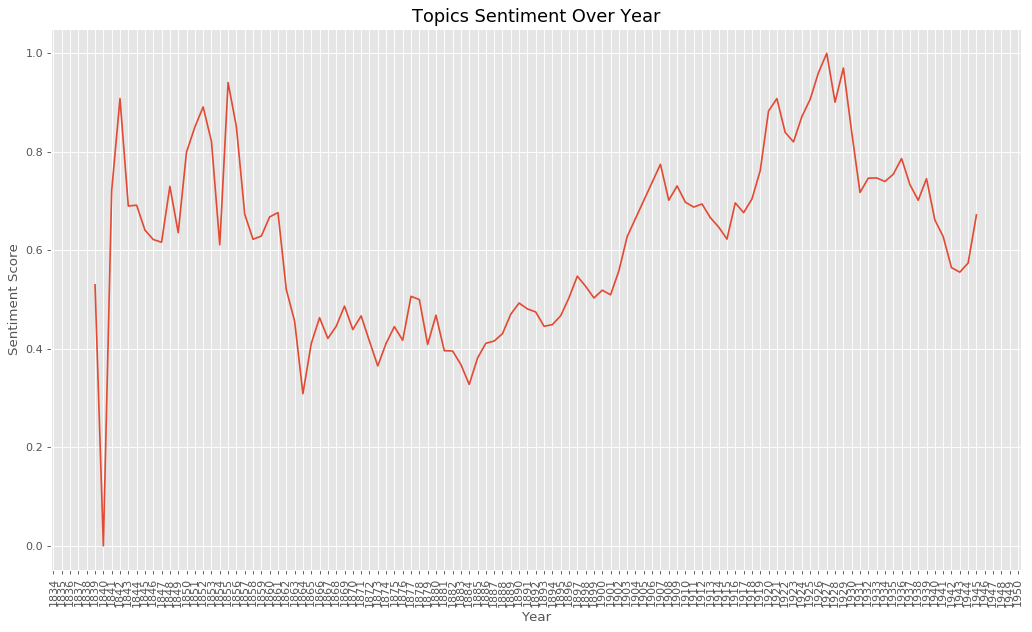

In [15]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=dpi)
year = mdates.YearLocator(month=1)
year_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

plt.plot_date(df_plt.index, df_plt['scaled'], '-')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title("Topics Sentiment Over Year", fontdict=dict(size=16))
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

**Although above process to generate sentiment based on topics are not very tight, it still display a reasonable answer for the question at the beginning. The first happy time begain in 1840 after The Treaty of Waitangi was assigned. The most happy period is after the WWI and drop quickly during the WWII.**

**The application of sentiment analysis on topic modeling is useful in historical research and social study.**

---

In [16]:
gc.collect()

5